In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, optimizers, models
import tensorflow as tf

from common import IM_SIZE, N_LABELS, LABELS
from utils import plot_confusion_matrix

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
data = pd.read_csv('fer2013/fer2013.csv')
label_binarizer = LabelBinarizer().fit(data['emotion'])

In [4]:
def preprocess(data, usage='Training'):
    ''' Returns train or test dataset '''
    groups = data.groupby('Usage')
    df_subset = groups.get_group(usage)
    
    imread = lambda x: np.fromstring(x, np.uint8, sep=' ')
    images = np.array([imread(x).reshape(*IM_SIZE,1) for x in df_subset['pixels']])
    images = images / float(images.max())
    
    y_bin = label_binarizer.transform(df_subset['emotion'])
    return images, y_bin
    
data_train = preprocess(data, 'Training')
data_test = preprocess(data, 'PrivateTest')

In [5]:
model = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=5, padding='same', input_shape=(48, 48, 1), activation='relu'),
    layers.Conv2D(32, kernel_size=5, padding='same', input_shape=(48, 48, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(*IM_SIZE, 1), activation='relu'),
    layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(*IM_SIZE, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_LABELS, activation='softmax')])

model.compile(optimizer=optimizers.Adam(3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
model.fit(data_train[0], data_train[1], epochs=10, batch_size=64, validation_data=data_test)

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 12s 422us/step - loss: 1.6939 - acc: 0.3237 - val_loss: 1.5349 - val_acc: 0.4143
Epoch 2/10
28709/28709 [==============================] - 11s 367us/step - loss: 1.4973 - acc: 0.4253 - val_loss: 1.4023 - val_acc: 0.4611
Epoch 3/10
28709/28709 [==============================] - 11s 369us/step - loss: 1.3814 - acc: 0.4726 - val_loss: 1.3341 - val_acc: 0.4901
Epoch 4/10
28709/28709 [==============================] - 11s 369us/step - loss: 1.2861 - acc: 0.5145 - val_loss: 1.2797 - val_acc: 0.5113
Epoch 5/10
28709/28709 [==============================] - 11s 369us/step - loss: 1.1993 - acc: 0.5475 - val_loss: 1.2429 - val_acc: 0.5235
Epoch 6/10
28709/28709 [==============================] - 11s 369us/step - loss: 1.1015 - acc: 0.5866 - val_loss: 1.2349 - val_acc: 0.5361
Epoch 7/10
28709/28709 [==============================] - 11s 371us/step - loss: 0.9965 - acc: 0.6280 - val_loss: 1.2

In [7]:
test_loss, test_acc = model.evaluate(*data_test)
print('Test accuracy:', test_acc)

3589/3589 [==============================] - 1s 154us/step - loss: 1.3694 - acc: 0.5567
Test accuracy: 0.556701


In [8]:
y_hat = model.predict(data_test[0]).argmax(axis=1)
conf_matrix = confusion_matrix(data_test[1].argmax(axis=1), y_hat)

Confusion matrix, without normalization
[[224   1  55  37  94   6  74]
 [ 15  21   6   4   7   0   2]
 [ 70   0 198  50 101  39  70]
 [ 39   1  33 678  69   7  52]
 [ 78   0  74  56 261  10 115]
 [ 16   1  51  37  19 266  26]
 [ 40   1  43  59 123  10 350]]


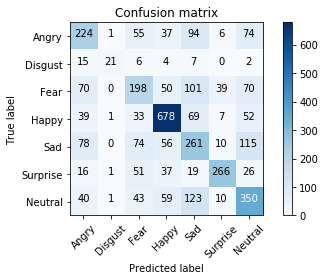

In [9]:
plot_confusion_matrix(conf_matrix, LABELS, normalize=0)

In [10]:
model.save('model.h5')